#### Import Libraries

In [1]:
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
import random
import time
import os
import sys

TensorFlow 2.x selected.


#### Import Data (and select part of it only)

In [2]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

train_data_fraction = 20000
x_train = x_train[0:train_data_fraction]
y_train = y_train[0:train_data_fraction]

11493376/11490434 [==============================] - 0s 0us/step


#### Define Data Size and Classes

In [0]:
# INPUT DATA
class_names = ['Zero','One', 'Two', 'Three', 'Four', 'Five','Six', 'Seven', 'Eight', 'Nine']
N_image_channels = 1

N_train = len(y_train)
N_test = len(y_test)
N_class = len(class_names)
image_shape = x_train.shape[1:3]
input_range = np.amax(x_train)

#### Plot images from set (random or in order)

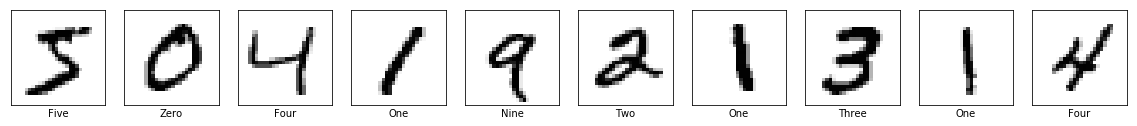

In [4]:
def plot_images(x_train, y_train, figures_to_plot=10, pick_random=True):
    n_rows = np.ceil(figures_to_plot/10)
    plot = plt.figure(figsize=[20,2*n_rows])
    for i in range(figures_to_plot):
        if pick_random: 
            pic_n = random.randint(0,len(x_train))
        else: pic_n = i
        plt.subplot(n_rows,10,i+1)
        plt.xticks([]); plt.yticks([])
        plt.imshow(x_train[pic_n], cmap=plt.cm.binary)
        plt.xlabel(class_names[y_train[pic_n]])
    plt.show()

plot_images(x_train, y_train, 10, False)

#### Pre-Proces Data

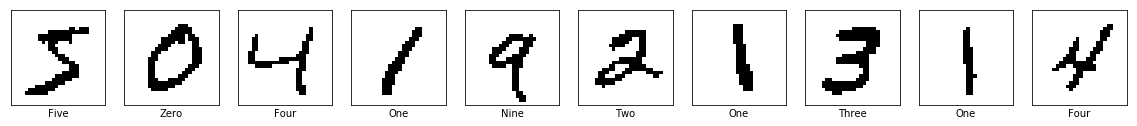

In [5]:
train_images = x_train/input_range
test_images = x_test/input_range

train_images[train_images >= 0.5] = 1.0
train_images[train_images < 0.5] = 0.0
test_images[test_images >= 0.5] = 1.0
test_images[test_images < 0.5] = 0.0

train_labels = y_train
test_labels = y_test

plot_images(train_images, train_labels, 10, False)

train_images = train_images.reshape(N_train, image_shape[0], image_shape[1], N_image_channels).astype('float32')
test_images = test_images.reshape(N_test, image_shape[0], image_shape[1], N_image_channels).astype('float32')

#### Create Dataset

In [0]:
batch_size = 100
shuffle_size_train = 20000
shuffle_size_test = 10000

train_dataset = tf.data.Dataset.from_tensor_slices((train_images)).shuffle(shuffle_size_train).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((test_images)).shuffle(shuffle_size_test).batch(batch_size)

#### Create Variational Autoencoder (VAE) Model

In [0]:
class CVAE(tf.keras.Model):
    def __init__(self, z_size):
        super(CVAE, self).__init__()
        self.z_size = z_size
        self.encoder_nn = tf.keras.models.Sequential([ 
                          tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
                          tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
                          tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
                          tf.keras.layers.Flatten(),
                          # No activation
                          tf.keras.layers.Dense(z_size*2)
                          ])

        self.decoder_nn = tf.keras.models.Sequential([
                          tf.keras.layers.InputLayer(input_shape=(z_size,)),
                          tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
                          tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
                          tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=(2, 2), padding="SAME", activation='relu'),
                          tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=(2, 2), padding="SAME", activation='relu'),
                          # No activation
                          tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=3, strides=(1, 1), padding="SAME")
                          ])
    @tf.function
    def encode(self, x):
        encoder_nn_output = self.encoder_nn(x)
        z_mean, z_logvar = tf.split(encoder_nn_output, num_or_size_splits=2, axis=1)
        return z_mean, z_logvar

    def reparameterize(self, z_mean, z_logvar):
        eps = tf.random.normal(shape=z_mean.shape)
        return eps * tf.exp(z_logvar * 0.5) + z_mean
    
    def decode(self, z):
        pixel_output = self.decoder_nn(z)
        return pixel_output

#### Define the loss function 

In [0]:
@tf.function
def compute_loss(model, x):
    z_mean, z_logvar = model.encode(x)
    z = model.reparameterize(z_mean, z_logvar)
    
    pixel_output = model.decode(z)
    #pixel_prob = tf.math.sigmoid(pixel_output)

    logpx_z_pixels = -tf.nn.sigmoid_cross_entropy_with_logits(logits=pixel_output, labels=x)
    #logpx_z_pixels = tf.math.log(pixel_prob + 1e-10)*x + tf.math.log(1-pixel_prob + 1e-10)*(1-x)
    logpx_z_images = tf.reduce_sum(logpx_z_pixels, axis=[1, 2, 3])
    logpx_z = tf.reduce_mean (logpx_z_images)
    
    logpz_z_parameters = -0.5 * (z ** 2.0 + np.log(2.0 * np.pi))
    logpz_z_vector = tf.reduce_sum(logpz_z_parameters, axis=1)
    logpz = tf.reduce_mean (logpz_z_vector)
    
    logqz_x_parameters = -0.5 * ((z - z_mean) ** 2.0 * tf.exp(-z_logvar) + z_logvar + np.log(2.0 * np.pi))
    logqz_x_vectors = tf.reduce_sum(logqz_x_parameters, axis=1)
    logqz_x = tf.reduce_mean (logqz_x_vectors)
    
    #kl_parameters = 0.5 * (1 + z_logvar - (z_mean ** 2) - tf.exp(-z_logvar))
    #kl_vectors = tf.reduce_sum(kl_parameters, axis=1)
    #kl = tf.reduce_mean(kl_vectors)
    
    return -(logpx_z + logpz - logqz_x) #### why negative?? ####
    #return -(logpx_z + kl)

#### Define the optimizer

In [0]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-4) #### why doesn't it work for 1e-3?? ####

#### Calculate the loss function gradients and input these to the optimizer

In [0]:
@tf.function
def compute_apply_gradients(model, x, optimizer):
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [0]:
epochs = 15
z_size = 50
model = CVAE(z_size)

In [0]:
z_random = tf.random.normal(shape=[16, z_size])

def generate_and_save_images(model, z_random): 
    generated_output = model.decode(z_random)
    generated_prob = tf.math.sigmoid(generated_output)
    fig = plt.figure(figsize=(4,4))

    for i in range(generated_prob.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(generated_prob[i, :, :, 0], cmap='gray')
        plt.axis('off')
    plt.show()

#### Train the data

In [0]:
generate_and_save_images(model, z_random)

for epoch in range(1, epochs + 1):
    start_time = time.time()
    for i, train_x in enumerate(train_dataset): 
        sys.stdout.write('\r'+'Epoch {} progress (%): {}'.format(epoch,100*(i+1)/(N_train/batch_size)))
        sys.stdout.flush()
        compute_apply_gradients(model, train_x, optimizer)
    end_time = time.time()

    average_loss = 0
    for i, test_x in enumerate(test_dataset):
        batch_loss = compute_loss(model, test_x)
        average_loss = (average_loss*i + batch_loss)/(i+1)
    print('\nTest set ELBO: {}; epoch running time: {}'.format(average_loss, end_time - start_time))
    
    generate_and_save_images(model, z_random)

In [0]:
# HELLO TEST CHANGE